In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as c

In [2]:
# geometries
from utils import save_geometries, load_geometries
source, base, description = 'Biovia', 'C', 'bond_lengths'
geom = load_geometries(source, base, description, load_metadata=True)

## Slater-Koster TB theory of atomic overlap 

In [3]:
# parametrizations obtained by optimization wrt experimental and ab initio data 

# HKS: Harrison, Koster, Slater
# proposed by Harrison, used by Hawke, only pz (Hückel method)
HKS_param = {'chi_ppp':-0.63, 'chi_sss':2.22, 'E_C':-6.7, 'E_N2':-7.9, 'E_N3':-10.9, 'E_O':-11.8} # in eV, , used by Hawke

# MMTS: Mantela, Morphis, Tassi, Simserides (2016)
# improved parametrization, paper not accessible, only pz (Hückel method)
MMTS_param = {'chi_ppp':-0.77, 'E_C':-6.56, 'E_N2':-9.62, 'E_N3':-11.48, 'E_O':-10.35} # in eV

# MSF: Mantela, Simserides, Felice (2021)
# includes all valence orbitals (beyond Hückel method), does not distinguish between N2 and N3 atoms
MSF_param = {'chi_sss':-1.32, 'chi_sps':-1.42, 'chi_ppp':-0.73, 'chi_pps':2.22, 'b': 0.7,  
             'E_Hs':-13.64, 'E_Cs':-13.18, 'E_Cp':-6.7, 'E_Ns':-14.51, 'E_Np':-9.55, 'E_Os':-15.03, 'E_Op':-11.52} # in eV

# Harrison form of bond integrals, modified with exponential decay
def V_pp(chi, d = 3.4e-10):
    d_0 = 1.35e-10 # typical length of covalent bonds
    V_pp = chi*c.hbar**2/(c.m_e*d_0**2)*np.e**(-2/d_0*(d-d_0))
    return V_pp/c.e # in eV

# Slater-Koster two-center overlap of pz orbitals (Hückel method)
def V_ij(phi, d = 3.4e-10, param = MSF_param):
    chi_pps, chi_ppp = param['chi_pps'], param['chi_ppp']
    V_pps, V_ppp = V_pp(chi_pps, d=d), V_pp(chi_ppp, d=d) # according to Harrison 
    return np.sin(phi)**2*V_pps + np.cos(phi)**2*V_ppp

## Single base

In [4]:
# Construct the Hamiltonian in the basis of the pz orbitals of a DNA base 
# Calculate HOMO and LUMO
from utils import load_geometries, H_particle

# all atoms of a base contributing pz orbitals to the delocalized pi system
get_basis_atoms = {'T': ['N1','C2','N3','C4','C5','C6','O2','O4'],
                   'A': ['N1','C2','N3','C4','C5','C6','N7','C8','N9','N6'],
                   'C': ['N1','C2','N3','C4','C5','C6','O2','N4'],
                   'G': ['N1','C2','N3','C4','C5','C6','N7','C8','N9','N2','O6'] }

# the coordination number determines if nitrogen contributes one or two electrons to the pi system
get_nitrogen_coordination_nums = {'T': ['3','','3','','','','',''],
                                  'A': ['2','','2','','','','2','','3','3'],
                                  'C': ['3','','2','','','','','3'],
                                  'G': ['3','','2','','','','2','','3','3',''] }

# number of electrons in the delocalized pi system
get_num_electrons = {'A':12, 'T':10, 'G':14, 'C':10}

def H_ij(base, atom1, atom2, param=HKS_param, source='Biovia'):
    # returns the overlap between two pz orbitals
    bond_lengths = load_geometries(source, base, 'bond_lengths')
    bond_length = [bond_lengths.get( key ) for key in [atom1+'_'+atom2,atom2+'_'+atom1] ]
    bond_length = next((length for length in bond_length if length is not None), None)
    if bond_length == None: 
        return 0
    else: 
        return V_pp(param['chi_ppp'], d = bond_length*1e-10)

def H_ii(atom, nitrogen_coordination_num, param=HKS_param):
    # returns the energy of each pz orbital
    energy = param[ 'E_'+atom[0]+nitrogen_coordination_num ] # the mask is needed since 
    return energy

def H(base, param=HKS_param):
    H = 0
    basis_atoms = get_basis_atoms[base]
    nitrogen_coordination_nums = get_nitrogen_coordination_nums[base]
    N = len(basis_atoms)
    for i, atom1 in enumerate(basis_atoms):
        for j, atom2 in enumerate(basis_atoms):
            if i==j: H += H_ii(atom1, nitrogen_coordination_nums[i], param=param) * H_particle(N,i,j)
            else: H += H_ij(base, atom1, atom2, param=param) * H_particle(N,i,j)
    return H

def get_energies(base):
    num_electrons = get_num_electrons[base]
    Ham = H(base) 
    w,v = np.linalg.eigh(Ham)
    E_HOMO, E_LUMO = w[num_electrons//2-1], w[num_electrons//2]
    HOMO, LUMO = np.real(v[:,num_electrons//2-1]), np.real(v[:,num_electrons//2])
    return E_HOMO, E_LUMO, HOMO, LUMO

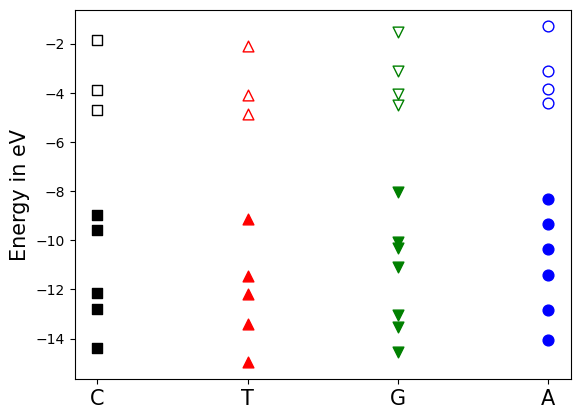

In [5]:
# plot the energy spectrum
marker_list = ['s','^','v','o']
color_list = ['k','r','g','b']

for i, base in enumerate(['C','T','G','A']):
    Ham = H(base) 
    w,v = np.linalg.eigh(Ham)
    occupied, unoccpied = w[: get_num_electrons[base]//2], w[get_num_electrons[base]//2:]
    plt.scatter( [i]*len(occupied), occupied, marker=marker_list[i], s=60, color=color_list[i])
    plt.scatter( [i]*len(unoccpied), unoccpied, marker=marker_list[i], s=60, color=color_list[i], facecolor='white')
plt.xticks(ticks=[0,1,2,3], labels=['C','T','G','A'],fontsize = 15)
plt.ylabel('Energy in eV', fontsize=15)
plt.show()

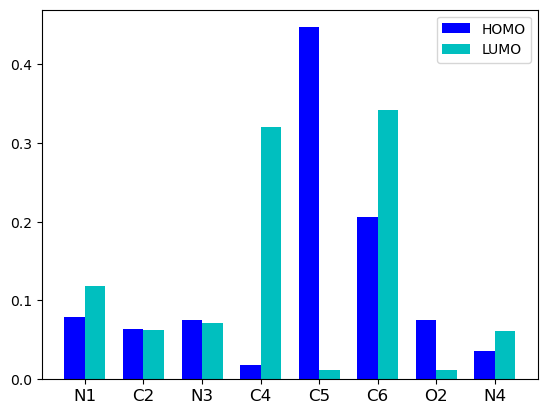

In [6]:
# plot HOMO and LUMO of a single DNA base
base = 'C'

_, _, HOMO, LUMO = get_energies(base)
categories = get_basis_atoms[base]
bar_width = 0.35
x = np.arange(len(categories))
plt.bar(x-bar_width/2, HOMO**2, width = bar_width, color='b', label='HOMO')
plt.bar(x+bar_width/2, LUMO**2, width = bar_width, color='c', label='LUMO')
plt.xticks(ticks=x, labels=categories,fontsize = 12)
plt.legend()
plt.show()

## Base pair

In [7]:
# Construct the Hamiltonian in the basis of the pz orbitals of a DNA base 
# Calculate HOMO and LUMO

def get_t(DNA_dimer, MO_type, description, direction):
    # description: 'base_pair' or 'single_base' (hopping between single bases or base-pairs)
    # direction: 'inter' or 'intra' (hopping between strands or in the strand) 
    # calculated according to eq.(5) in Hawke2010
    if direction == 'inter': phi = 0
    elif direction =='intra': phi = 36/360*2*np.pi
     # the distance depends on which orbitals are considered and is most likely not uniform!
    V = V_ij(phi, d=3.4e-10)
    if description == 'base_pair':
        get_bp = {'A':'AT', 'T':'TA', 'G':'GC', 'C':'CG'}
        HOMO1, LUMO1 = get_bp_MO( get_bp[DNA_dimer[0]] )
        HOMO2, LUMO2 = get_bp_MO( get_bp[DNA_dimer[1]] )
    elif description == 'single_base':
        _, _, HOMO1, LUMO1 = get_energies( DNA_dimer[0] )
        _, _, HOMO2, LUMO2 = get_energies( DNA_dimer[1] )
    if MO_type == 'HOMO': MO1, MO2 = HOMO1, HOMO2
    elif MO_type == 'LUMO': MO1, MO2 = LUMO1, LUMO2
    t = V * np.sum( [c_i*c_j for c_i in MO1 for c_j in MO2] )
    return t

def H_bp(base_pair, MO_type):
    t = get_t(base_pair, MO_type, 'single_base', 'inter')
    Ham = np.array( [[0,t],[t,0]] )
    for i, base in enumerate(base_pair):
        E_HOMO, E_LUMO, HOMO, LUMO = get_energies( base )
        if MO_type == 'HOMO': Ham[i,i] = E_HOMO
        elif MO_type == 'LUMO': Ham[i,i] = E_LUMO
    return Ham

def get_energies_bp(base_pair):
    Ham = H_bp(base_pair, 'LUMO')
    w,v = np.linalg.eigh(Ham)
    E_bp_LUMO, bp_LUMO = w[0], np.real(v[:,0])
    Ham = H_bp(base_pair, 'HOMO')
    w,v = np.linalg.eigh(Ham)
    E_bp_HOMO, bp_HOMO = w[1], np.real(v[:,1])
    return E_bp_HOMO, E_bp_LUMO, bp_HOMO, bp_LUMO

def get_bp_MO(base_pair):
    _, _, bp_HOMO, bp_LUMO = get_energies_bp(base_pair)
    bp_HOMO_tot, bp_LUMO_tot = [],[]
    for i, base in enumerate(base_pair):
        _, _, HOMO, LUMO = get_energies(base)
        bp_HOMO_tot.extend( bp_HOMO[i]*HOMO )
        bp_LUMO_tot.extend( bp_LUMO[i]*LUMO )
    return bp_HOMO_tot, bp_LUMO_tot

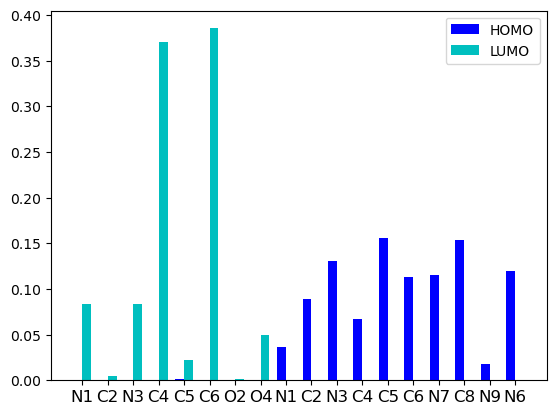

In [8]:
# plot HOMO and LUMO of a DNA base-pair
base_pair = 'TA'

HOMO, LUMO = get_bp_MO(base_pair)
categories = get_basis_atoms[ base_pair[0] ] + get_basis_atoms[ base_pair[1] ]
bar_width = 0.35
x = np.arange(len(categories))
plt.bar(x-bar_width/2, np.array(HOMO)**2, width = bar_width, color='b', label='HOMO')
plt.bar(x+bar_width/2, np.array(LUMO)**2, width = bar_width, color='c', label='LUMO')
plt.xticks(ticks=x, labels=categories,fontsize = 12)
plt.legend()
plt.show()

## TB parameters

In [244]:
# Using the HOMO and LUMO for single bases and base pairs one can calculate hopping parameters with eq. (5) of Hawke 2010
# there must be a problem with the implementation of eq. (5), I suspect that V is not uniform because the distances change!

def get_t_fast(DNA_dimer, MO_type, get_HOMO, get_LUMO, direction):
    # fast version of the function get_t()
    if direction == 'inter': phi = 0
    elif direction =='intra': phi = 36/360*2*np.pi
    # the distance depends on which orbitals are considered and is most likely not uniform!
    V = V_ij(phi, d=3.4e-10) 
    if MO_type == 'HOMO': MO1, MO2 = get_HOMO[ DNA_dimer[0] ], get_HOMO[ DNA_dimer[1] ]
    elif MO_type == 'LUMO': MO1, MO2 = get_LUMO[ DNA_dimer[0] ], get_LUMO[ DNA_dimer[1] ]
    t = V * np.sum( [c_i*c_j for c_i in MO1 for c_j in MO2] )
    return t
    
def get_TB_params_single_base():
    get_HOMO, get_LUMO = {},{}
    for base in ['A','T','G','C']:
        _,_, HOMO, LUMO = get_energies( base )
        get_HOMO[base], get_LUMO[base] = HOMO, LUMO
    TB_params = {}
    for MO_type, base1, base2 in itertools.product( ['HOMO','LUMO'], ['A','T','G','C'], ['A','T','G','C'] ): 
        DNA_dimer = base1 + base2
        h_val = int( get_t_fast(DNA_dimer, MO_type, get_HOMO, get_LUMO, 'inter')*1000) # single base hopping between strands (inside the base-pair)
        t_val = int( get_t_fast(DNA_dimer, MO_type, get_HOMO, get_LUMO, 'intra')*1000) # single base hopping in the strand 
        TB_params['h_'+base1+base2+'_'+MO_type] = h_val # in meV
        TB_params['t_'+base1+base2+'_'+MO_type] = t_val # in meV
    return TB_params

def get_TB_params_base_pair():
    get_HOMO, get_LUMO = {},{}
    for base_pair in ['AT','TA','GC','CG']:
        HOMO, LUMO = get_bp_MO( base_pair )
        get_HOMO[base_pair[0]], get_LUMO[base_pair[0]] = HOMO, LUMO
    TB_params = {}
    for MO_type, base1, base2 in itertools.product( ['HOMO','LUMO'], ['A','T','G','C'], ['A','T','G','C'] ): 
        DNA_dimer = base1 + base2
        t_val = int( get_t_fast(DNA_dimer, MO_type, get_HOMO, get_LUMO, 'intra')*1000)
        TB_params['t_'+base1+base2+'_'+MO_type] = t_val # in meV
    return TB_params

get_TB_params_base_pair()

## Rest

In [9]:
phi1, phi2 = 0, 36
V1 = V_ij(2*np.pi*phi1/360) # interstrand 
V2 = V_ij(2*np.pi*phi2/360) # intrastrand
V1/V2 
# this indicates that interstrand coupling should be stronger, but that contradicts experimental findings (e.g., Crespo-Hernandez2005)

-2.524205284827746

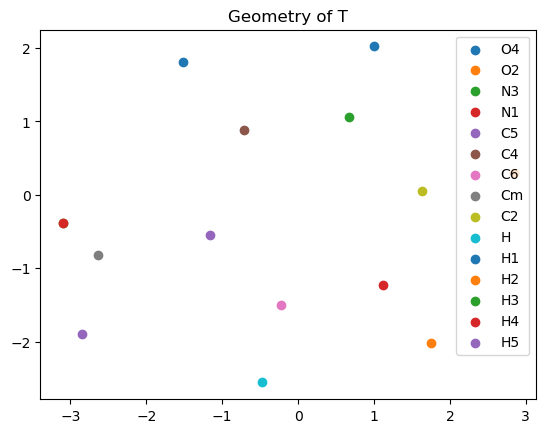

In [10]:
# plot coordinates with PubChem data
source, base, description = 'PubChem', 'T', 'coordinates'
coordinates = load_geometries(source, base, description)

for atom, coordinate in coordinates.items():
    plt.scatter(coordinate[0], coordinate[1], label=atom)
plt.title('Geometry of '+base)
plt.legend()
plt.show()